# Lab 10 -- Decision Trees for Regression

Compared to last week, this is a very simple lab <span style="font-size:20pt;">😃</span> You'll have fun programming!

You will implement the **Classification and Regression Tree (CART)** algorithm from scratch.

The lab is broken down into the following pieces:

* Regression Criterion
* Creating Splits
* Buiding a Tree
* Making a prediction

## Exercise 1 -- Download and load the dataset

We will be using the usual Boston Housing dataset, which is available to download from ECLASS

* Download the file
* Read it and separate the target variable from the features.
* Make a 80/10/10 train/validation/test split

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
# your code here
data = pd.read_csv("data/BostonHousing.txt")
data.head(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


The target variable will be as usual `MEDV`. Use the rest as features.

In [4]:
# your code here
X = data.drop(columns=['medv']).values  # Features
y = data['medv'].values  # Target variable

# Perform an 80/10/10 train/validation/test split
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, train_size=0.80, random_state=13)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=13)

## Exercise 2 -- Optimization Criterion

For regression, a simple criterion to optimize is to minimize the sum of squared errors for a given region. This is, for all datapoints in a region with size, we minimize:

$$\sum_{i=1}^N(y_i - \hat{y})^2$$

where $N$ is the number of datapoits in the region and $\hat{y}$ is the mean value of the region for the target variable. 

Implement such a function using the description below.

Please, don't use an existing implementation, refer to the [book](https://www.statlearning.com/s/ISLRSeventhPrinting.pdf), and if you need help, ask questions!

In [5]:
def regression_criterion(region):
    """
    Implements the sum of squared error criterion in a region
    
    Parameters
    ----------
    region : ndarray
        Array of shape (N,) containing the values of the target values 
        for N datapoints in the training set.
    
    Returns
    -------
    float
        The sum of squared error
        
    Note
    ----
    The error for an empty region should be infinity (use: float("inf"))
    This avoids creating empty regions
    """
    # your code here
    if len(region) == 0:
        return float("inf")
    
    if isinstance(region, pd.DataFrame) or isinstance(region, pd.Series):
        region = region.values
    
    mean_value = np.mean(region)
    squared_errors = (region - mean_value) ** 2
    return np.sum(squared_errors)

In [6]:
# test your code
rng = np.random.default_rng(0)
print(regression_criterion(rng.random(size=40)))
print(regression_criterion(np.ones(10)))
print(regression_criterion(np.zeros(10)))
print(regression_criterion(np.array([])))

3.6200679838629544
0.0
0.0
inf


## Exercise 3 -- Make a split

In [7]:
def split_region(region, feature_index, tau):
    """
    Given a region, splits it based on the feature indicated by
    `feature_index`, the region will be split in two, where
    one side will contain all points with the feature with values 
    lower than `tau`, and the other split will contain the 
    remaining datapoints.
    
    Parameters
    ----------
    region : array of size (n_samples, n_features)
        a partition of the dataset (or the full dataset) to be split
    feature_index : int
        the index of the feature (column of the region array) used to make this partition
    tau : float
        The threshold used to make this partition
        
    Return
    ------
    left_partition : array
        indices of the datapoints in `region` where feature < `tau`
    right_partition : array
        indices of the datapoints in `region` where feature >= `tau` 
    """
    # your code here
    
    if isinstance(region, pd.DataFrame):
        feature_values = region.iloc[:, feature_index].values
    else:
        feature_values = region[:, feature_index]
    
    left_partition = np.where(feature_values < tau)[0]
    right_partition = np.where(feature_values >= tau)[0]
    
    return left_partition, right_partition

In [8]:
l, r = split_region(X_train, 2, 10)
print(l.shape, r.shape)

(220,) (184,)


## Exercise 4 -- Find the best split

The strategy is quite simple (as well as inefficient), but it helps to reinforce the concepts.
We are going to use a greedy, exhaustive algorithm to select splits, selecting the `feature_index` and the `tau` that minimizes the Regression Criterion

In [9]:
def get_split(X, y):
    """
    Given a dataset (full or partial), splits it on the feature of that minimizes the sum of squared error
    
    Parameters
    ----------
    X : array (n_samples, n_features)
        features 
    y : array (n_samples, )
        labels
    
    Returns
    -------
    decision : dictionary
        keys are:
        * 'feature_index' -> an integer that indicates the feature (column) of `X` on which the data is split
        * 'tau' -> the threshold used to make the split
        * 'left_region' -> array of indices where the `feature_index`th feature of X is lower than `tau`
        * 'right_region' -> indices not in `low_region`
    """
    # your code here
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values
    
    best_criterion = float('inf')
    best_feature_index = -1
    best_tau = None
    best_left_region = None
    best_right_region = None
    
    _, n_features = X.shape
    
    for feature_index in range(n_features):
        feature_values = X[:, feature_index]
        possible_taus = np.unique(feature_values)
        
        for tau in possible_taus:
            left_indices, right_indices = split_region(X, feature_index, tau)
            
            left_criterion = regression_criterion(y[left_indices])
            right_criterion = regression_criterion(y[right_indices])
            
            total_criterion = left_criterion + right_criterion
            
            if total_criterion < best_criterion:
                best_criterion = total_criterion
                best_feature_index = feature_index
                best_tau = tau
                best_left_region = left_indices
                best_right_region = right_indices
    
    decision = {
        'feature_index': best_feature_index,
        'tau': best_tau,
        'left_region': best_left_region,
        'right_region': best_right_region
    }
    
    return decision

In [10]:
get_split(X_train[:15, :], y_train[:15])

{'feature_index': 5,
 'tau': 8.297,
 'left_region': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14]),
 'right_region': array([9])}

## Exercise 5 -- Recursive Splitting

The test above is an example on how to find the root node of our decision tree. The algorithm now is a greedy search until we reach a stop criterion. To find the actual root node of our decision tree, you must provide the whole training set, not just a slice of 15 rows as the test above.

The trivial stopping criterion is to recursively grow the tree until each split contains a single point (perfect node purity). If we go that far, it normally means we are overfitting.

You will implement these criteria to stop the growth:

* A node is a leaf if:
    * It has less than `min_samples` datapoints
    * It is at the `max_depth` level from the root (each split creates a new level)
    * The criterion is `0`



In [11]:
def recursive_growth(node, min_samples, max_depth, current_depth, X, y):
    """
    Recursively grows a decision tree.
    
    Parameters
    ----------
    node : dictionary
        If the node is terminal, it contains only the "value" key, which determines the value to be used as a prediction.
        If the node is not terminal, the dictionary has the structure defined by `get_split`
    min_samples : int
        parameter for stopping criterion if a node has <= min_samples datapoints
    max_depth : int
        parameter for stopping criterion if a node belongs to this depth
    depth : int
        current distance from the root
    X : array (n_samples, n_features)
        features (full dataset)
    y : array (n_samples, )
        labels (full dataset)
    
    Notes
    -----
    To create a terminal node, a dictionary is created with a single "value" key, with a value that
    is the mean of the target variable
    
    'left' and 'right' keys are added to non-terminal nodes, which contain (possibly terminal) nodes 
    from higher levels of the tree:
    'left' corresponds to the 'left_region' key, and 'right' to the 'right_region' key
    """
    # your code here
    if current_depth >= max_depth:
        node['value'] = np.mean(y)
        return

    # Parar se o número de amostras for menor que min_samples
    if len(y) <= min_samples:
        node['value'] = np.mean(y)
        return

    # Encontrar a melhor divisão
    decision = get_split(X, y)
    if decision['feature_index'] is None:
        node['value'] = np.mean(y)
        return
    
    # Se a divisão não melhora o critério, fazer o nó ser terminal
    left_indices = decision['left_region']
    right_indices = decision['right_region']
    if regression_criterion(left_indices) == 0 or regression_criterion(right_indices) == 0:
        node['value'] = np.mean(y)
        return
    node.update(decision)
    
    # Crescer a sub-árvore esquerda
    left_node = {}
    recursive_growth(left_node, min_samples, max_depth, current_depth + 1, X[left_indices], y[left_indices])
    node['left'] = left_node
    
    # Crescer a sub-árvore direita
    right_node = {}
    recursive_growth(right_node, min_samples, max_depth, current_depth + 1, X[right_indices], y[right_indices])
    node['right'] = right_node

In [12]:
k = 100
test_root = get_split(X_train[:k, :], y_train[:k])
recursive_growth(test_root, 5, 3, 1, X_train[:k, :], y_train[:k])

Below we provide code to visualise the generated tree!

In [13]:
def print_tree(node, depth):
    if 'value' in node.keys():
        print('.  '*(depth-1), f"[{node['value']}]")
    else:
        print('.  '*depth, f'X_{node["feature_index"]} < {node["tau"]}')
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)


In [14]:
print_tree(test_root, 0)

 X_5 < 6.563
.   X_12 < 18.07
.   [20.766666666666666]
.   [10.641666666666666]
.   X_5 < 8.04
.   [29.227272727272727]
.   [40.5]


# Exercise 6 -- Make a Prediction
Use the a node to predict the class of a compatible dataset

In [15]:
def predict_sample(node, sample):
    """
    Makes a prediction based on the decision tree defined by `node`
    
    Parameters
    ----------
    node : dictionary
        A node created one of the methods above
    sample : array of size (n_features,)
        a sample datapoint
    """
    # your code here
    if 'value' in node:
        return node['value']
    
    # Caso contrário, siga a árvore de decisão recursivamente
    feature_index = node['feature_index']
    tau = node['tau']
    
    if sample[feature_index] < tau:
        return predict_sample(node['left'], sample)
    else:
        return predict_sample(node['right'], sample)
        
def predict(node, X):
    """
    Makes a prediction based on the decision tree defined by `node`
    
    Parameters
    ----------
    node : dictionary
        A node created one of the methods above
    X : array of size (n_samples, n_features)
        n_samples predictions will be made
    """
    # your code here
    predictions = np.array([predict_sample(node, sample) for sample in X])
    
    return predictions

Now use the functions defined above to calculate the RMSE of the validation set. 
* Try first with `min_samples=20` and `max_depth=6` (for this values you should get a validation RMSE of ~8.8)

Then, experiment with different values for the stopping criteria.

In [16]:
# your code here
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Definindo os parâmetros de parada
min_samples = 20
max_depth = 6

# Inicializando o nó raiz
root_node = {}

# Construindo a árvore de decisão
recursive_growth(root_node, min_samples, max_depth, current_depth=1, X=X_train, y=y_train)

# Fazendo previsões no conjunto de validação
y_val_pred = predict(root_node, X_val)

# Calculando o RMSE no conjunto de validação
validation_rmse = rmse(y_val, y_val_pred)
print(f'Validation RMSE (min_samples={min_samples}, max_depth={max_depth}): {validation_rmse:.2f}')

Validation RMSE (min_samples=20, max_depth=6): 4.19


In [18]:
def se_criterion(region):
    """
    Implements the sum of squared error criterion in a region
    
    Parameters
    ----------
    region : ndarray
        Array of shape (N,) containing the values of the target values 
        for N datapoints in the training set.
    
    Returns
    -------
    float
        The sum of squared error
        
    Note
    ----
    The error for an empty region should be infinity (use: float("inf"))
    This avoids creating empty regions
    """
    # your code here
    if len(region) == 0:
        return float("inf")
    
    if isinstance(region, pd.DataFrame) or isinstance(region, pd.Series):
        region = region.values
    
    mean_value = np.mean(region)
    squared_errors = (region - mean_value) ** 2
    
    return np.sum(squared_errors)


class DecisionTree:
    def __init__(self, criterion = se_criterion, max_depth=4, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.tree = None

    def fit(self, X_train, y_train):
        train_data = np.column_stack((X_train, y_train))  # Concatenando features e labels
        self.tree = self.create_tree(train_data, 0)  # Iniciando a construção da árvore

    def predict(self, X_test):
        predictions = np.array([self.predict_sample(x, self.tree) for x in X_test])
        return predictions

    def create_tree(self, data, current_depth):
        if current_depth > self.max_depth:
            return None
        
        split_data, split_feature_idx, split_feature_val = self.find_bestsplit(data)

        node = TreeNode(data, split_feature_idx, split_feature_val, self.criterion(data[:,-1])/data.shape[0])
        
        if split_data is None:
            return node
        
        if len(split_data[0]) <= self.min_samples_leaf or len(split_data[1]) <= self.min_samples_leaf:
            return node

        current_depth += 1
        node.left = self.create_tree(split_data[0], current_depth)
        node.right = self.create_tree(split_data[1], current_depth)

        return node

    def find_bestsplit(self, data):
        if isinstance(data, pd.DataFrame):
            data = data.values
        if isinstance(data, pd.Series):
            data = data.values
        
        best_sq_error = float('inf')
        best_feature_index = None
        best_tau = None
        regions = None

        _, n_features = data.shape
        
        for feature_index in range(n_features - 1): 
            feature_values = data[:, feature_index]
            possible_taus = np.unique(feature_values)
            for tau in possible_taus:
                left, right = self.split(data, feature_index, tau)
                sq_error = self.criterion(left[:, -1]) + self.criterion(right[:, -1])
                
                if sq_error < best_sq_error and len(left)>self.min_samples_leaf and len(right)>self.min_samples_leaf:
                    best_sq_error = sq_error
                    best_feature_index = feature_index
                    best_tau = tau
                    regions = (left, right)

        return regions, best_feature_index, best_tau

    def split(self, data, feature_index, tau, indices = False):
        if isinstance(data, pd.DataFrame):
            feature_values = data.iloc[:, feature_index].values
        else:
            feature_values = data[:, feature_index]
            
        left_indices = np.where(feature_values <= tau)[0] 
        right_indices = np.where(feature_values > tau)[0] 
        
        if indices: 
            return left_indices, right_indices
        
        left_partition = data[left_indices]
        right_partition = data[right_indices]
        
        return left_partition, right_partition

    def predict_sample(self, sample, node):
        if node.is_leaf:
            return np.mean(node.data[:, -1])  # Retorna a média das previsões do nó folha
        if sample[node.feature_idx] < node.feature_val:
            return self.predict_sample(sample, node.left)
        else:
            return self.predict_sample(sample, node.right)
    
    def print_tree(self):
        self._print_tree(self.tree)

    def _print_tree(self, node, depth=0, prefix=""):
        if node is None:
            return
        indent = "  " * depth
        if node.is_leaf:
            print(f"{indent}{prefix}Leaf: Predict {np.mean(node.data[:, -1]):.2f}, Samples: {len(node.data)}, sq_error = {node.sq_error:.2f}")
        else:
            print(f"{indent}{prefix}Node: Feature {node.feature_idx}, Threshold {node.feature_val:.2f}, sq_error = {node.sq_error:.2f}")
            self._print_tree(node.left, depth + 1, prefix="L--> ")
            self._print_tree(node.right, depth + 1, prefix="R--> ")

class TreeNode:
    def __init__(self, data, feature_idx, feature_val, sq_error):
        self.data = data
        self.feature_idx = feature_idx
        self.feature_val = feature_val
        self.sq_error = sq_error
        self.left = None
        self.right = None

    @property
    def is_leaf(self):
        return self.left is None and self.right is None

tree = DecisionTree(max_depth=max_depth, min_samples_leaf=min_samples,criterion=se_criterion)
tree.fit(X_train, y_train)

# Fazendo previsões no conjunto de validação
y_val_pred = tree.predict(X_val)

# Calculando o RMSE no conjunto de validação
validation_rmse = rmse(y_val, y_val_pred)
print(f'Validation RMSE (min_samples={min_samples}, max_depth={max_depth}): {validation_rmse:.2f}')

Validation RMSE (min_samples=20, max_depth=6): 4.25


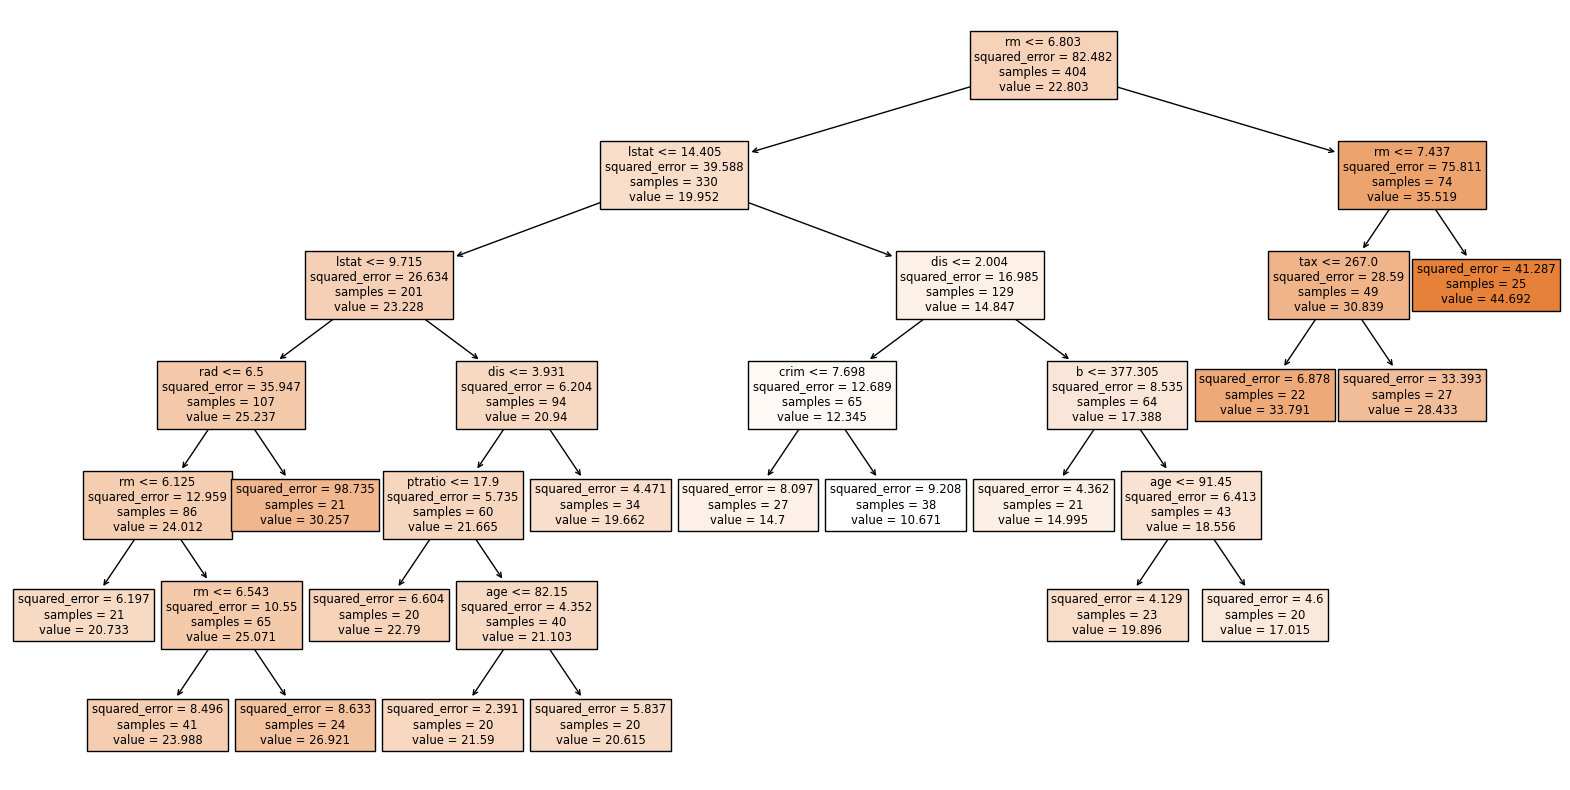

Validation RMSE (min_samples=20, max_depth=6): 4.23


In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

tree = DecisionTreeRegressor(max_depth=6, min_samples_leaf=20, criterion='squared_error')
tree.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=data.columns[:-1], filled=True)
plt.show()

y_val_pred = tree.predict(X_val)

# Calculando o RMSE no conjunto de validação
validation_rmse = rmse(y_val, y_val_pred)
print(f'Validation RMSE (min_samples={min_samples}, max_depth={max_depth}): {validation_rmse:.2f}')